In [18]:
!pip install ucimlrepo
#!pip install category_encoders

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from ucimlrepo import fetch_ucirepo

In [20]:
#Importing the Data
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/'Data Mining Project'

folder=('/content/drive/My Drive/Data Mining Project/')

import os
from google.colab import drive

df = pd.read_csv(folder+'MTA_Congestion_Relief_Zone_Vehicle_Entries__Beginning_2025_20250319.csv',na_values='?')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Data Mining Project


In [21]:
#Cleaning the Data
res = df.columns
print(res)
dfs = df.drop(['Toll Hour', 'Toll 10 Minute Block', 'Day of Week Int', 'Time Period', 'Excluded Roadway Entries' ], axis = 1) #df simple with redundacy and unnecessary columns removed

coltype={'Toll Week':'datetime64[ns]', 'Minute of Hour' : 'Int64', 'Hour of Day':'Int64', 'Day of Week':'category', 'Vehicle Class':'category', 'Detection Group':'category', 'Detection Region':'category', 'CRZ Entries':'Int64'}#'Excluded Roadway Entries':'Int64' }

print(dfs[dfs.isna().any(axis=1)]) # shows NaN values in data frame if it exists
dfs = dfs.astype(coltype) #Assigning data types
dfs.info()


Index(['Toll Date', 'Toll Hour', 'Toll 10 Minute Block', 'Minute of Hour',
       'Hour of Day', 'Day of Week Int', 'Day of Week', 'Toll Week',
       'Time Period', 'Vehicle Class', 'Detection Group', 'Detection Region',
       'CRZ Entries', 'Excluded Roadway Entries'],
      dtype='object')
Empty DataFrame
Columns: [Toll Date, Minute of Hour, Hour of Day, Day of Week, Toll Week, Vehicle Class, Detection Group, Detection Region, CRZ Entries]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653184 entries, 0 to 653183
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Toll Date         653184 non-null  object        
 1   Minute of Hour    653184 non-null  Int64         
 2   Hour of Day       653184 non-null  Int64         
 3   Day of Week       653184 non-null  category      
 4   Toll Week         653184 non-null  datetime64[ns]
 5   Vehicle Class     653184 non-null  categor

In [22]:
dfs.head()

,Toll Date,Minute of Hour,Hour of Day,Day of Week,Toll Week,Vehicle Class,Detection Group,Detection Region,CRZ Entries
0,03/08/2025,50,23,Saturday,2025-03-02,"1 - Cars, Pickups and Vans",Brooklyn Bridge,Brooklyn,102
1,03/08/2025,50,23,Saturday,2025-03-02,TLC Taxi/FHV,West Side Highway at 60th St,West Side Highway,140
2,03/08/2025,50,23,Saturday,2025-03-02,TLC Taxi/FHV,West 60th St,West 60th St,213
3,03/08/2025,50,23,Saturday,2025-03-02,TLC Taxi/FHV,Queensboro Bridge,Queens,70
4,03/08/2025,50,23,Saturday,2025-03-02,TLC Taxi/FHV,Queens Midtown Tunnel,Queens,132


In [23]:
 #Converting Day of Week to numeric values
dfs.info()
days = {"Monday" : '1', "Tuesday" : '2', "Wednesday" : '3', "Thursday" : '4', "Friday" : '5', "Saturday" : '6', "Sunday" : '7'}

dfs['Day of Week'] = dfs['Day of Week'].map(days)
dfs.head()
dfs['Day of Week'] = dfs['Day of Week'].astype('Int64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653184 entries, 0 to 653183
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Toll Date         653184 non-null  object        
 1   Minute of Hour    653184 non-null  Int64         
 2   Hour of Day       653184 non-null  Int64         
 3   Day of Week       653184 non-null  category      
 4   Toll Week         653184 non-null  datetime64[ns]
 5   Vehicle Class     653184 non-null  category      
 6   Detection Group   653184 non-null  category      
 7   Detection Region  653184 non-null  category      
 8   CRZ Entries       653184 non-null  Int64         
dtypes: Int64(3), category(4), datetime64[ns](1), object(1)
memory usage: 29.3+ MB


In [24]:
#We make two groupings putting everything that was at the same time together if it had the same detector, location, and timing (but different vehicle type)
locations_grouped = dfs.drop(['Detection Group', 'Detection Region'], axis=1)
locations_grouped = locations_grouped.groupby(['Toll Week', 'Hour of Day', 'Day of Week', 'Minute of Hour']).agg(total_vehicles=('CRZ Entries', 'sum'))
#print('~~~~~~~~~~~~~~~~~~~~~~~')
print(locations_grouped.head())


                                                   total_vehicles
Toll Week  Hour of Day Day of Week Minute of Hour                
2025-01-05 0           1           0                         1528
                                   10                        1423
                                   20                        1400
                                   30                        1277
                                   40                        1160


In [25]:
#We will create a categorized version of CRZ enteries based on location.

CRZ_categories_l = locations_grouped.reset_index()['total_vehicles'].copy()

locations_grouped = locations_grouped.reset_index()
#locations_grouped['total_vehicles'] = CRZ_categories_l
locations_grouped.head()
#This is the end of cleaning and combining data

,Toll Week,Hour of Day,Day of Week,Minute of Hour,total_vehicles
0,2025-01-05,0,1,0,1528
1,2025-01-05,0,1,10,1423
2,2025-01-05,0,1,20,1400
3,2025-01-05,0,1,30,1277
4,2025-01-05,0,1,40,1160


We now have things sorted to view all traffic by a given detector and by given locations.

In [26]:
attr = locations_grouped

attr['Toll Week'] = pd.to_numeric(attr['Toll Week'])
target = CRZ_categories_l
attr.head()

,Toll Week,Hour of Day,Day of Week,Minute of Hour,total_vehicles
0,1736035200000000000,0,1,0,1528
1,1736035200000000000,0,1,10,1423
2,1736035200000000000,0,1,20,1400
3,1736035200000000000,0,1,30,1277
4,1736035200000000000,0,1,40,1160


In [27]:
n_estimators = 100 #Number of trees
contamination = 0.005 # Expected proportion of anomalies
sample_size = 256 # Number of samples used to train each tree

In [28]:
# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, max_samples=sample_size, random_state=73)
iso_forest.fit(attr)

IsolationForest(contamination=0.005, max_samples=256, random_state=73)

In [29]:
# Calculate anomaly scores and classify anomalies
data = attr.loc[attr.index].copy()
data['anomaly_score'] = iso_forest.decision_function(attr)
data['anomaly'] = iso_forest.predict(attr)

data['anomaly'].value_counts()
data.head()

,Toll Week,Hour of Day,Day of Week,Minute of Hour,total_vehicles,anomaly_score,anomaly
0,1736035200000000000,0,1,0,1528,-0.016218,-1
1,1736035200000000000,0,1,10,1423,0.011085,1
2,1736035200000000000,0,1,20,1400,0.030355,1
3,1736035200000000000,0,1,30,1277,0.020528,1
4,1736035200000000000,0,1,40,1160,0.008906,1


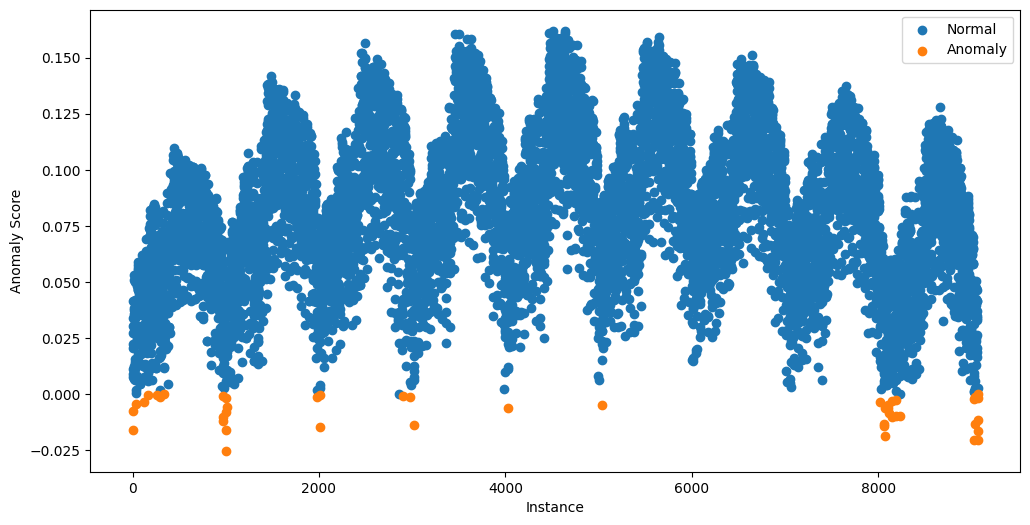

In [30]:
# Visualization of the results
plt.figure(figsize=(12, 6))

# Plot normal instances
normal = data[data['anomaly'] == 1]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data[data['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

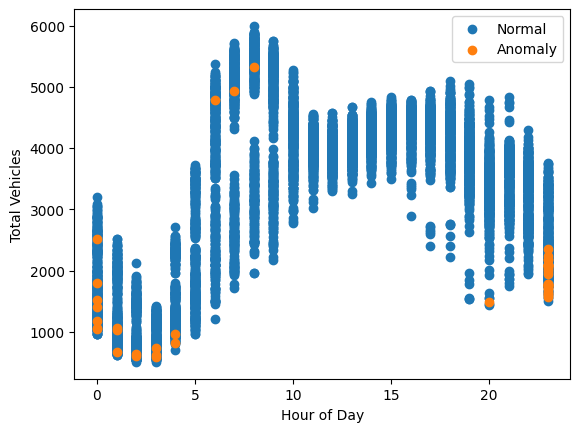

In [31]:
# Visualization of the results

# Plot non-anomalies then anomalies
plt.scatter(normal['Hour of Day'], normal['total_vehicles'], label='Normal')
plt.scatter(anomalies['Hour of Day'], anomalies['total_vehicles'], label='Anomaly')
plt.xlabel("Hour of Day")
plt.ylabel("Total Vehicles")
plt.legend()
plt.show()

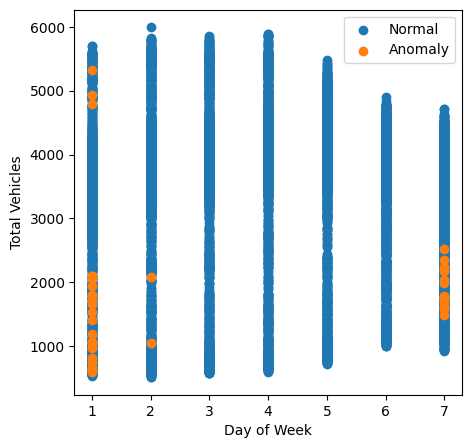

In [32]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(normal['Day of Week'], normal['total_vehicles'], label='Normal')
plt.scatter(anomalies['Day of Week'], anomalies['total_vehicles'], label='Anomaly')
plt.xlabel("Day of Week")
plt.ylabel("Total Vehicles")
plt.legend()
plt.show()

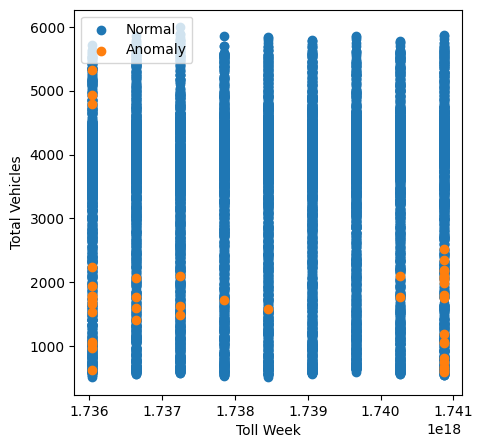

In [33]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(normal['Toll Week'], normal['total_vehicles'], label='Normal')
plt.scatter(anomalies['Toll Week'], anomalies['total_vehicles'], label='Anomaly')
plt.xlabel("Toll Week")
plt.ylabel("Total Vehicles")
plt.legend()
plt.show()

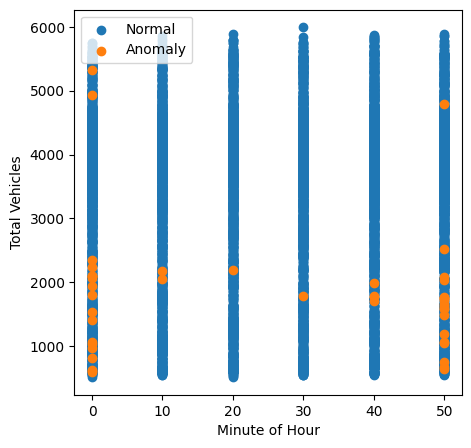

In [34]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(normal['Minute of Hour'], normal['total_vehicles'], label='Normal')
plt.scatter(anomalies['Minute of Hour'], anomalies['total_vehicles'], label='Anomaly')
plt.xlabel("Minute of Hour")
plt.ylabel("Total Vehicles")
plt.legend()
plt.show()

In conclusion, a majority of these anomalies seem to be due to a combination of factors and are not individually significant. There is one takeaway though, which is that traffic levels are less predictable in the evening and night. The two distinct traffic levels from around 6am-8am are no doubt due to the difference between weekend traffic and weekday rush hour. It also seems there are no weeks significantly different than others, although over an entire year there may be instances that stand out, for example Christmas week traffic.